# 9 Comparing binomial rates

In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from theano import tensor as tt
from scipy import stats
from scipy.stats.kde import gaussian_kde
from scipy.stats import cauchy
    
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-darkgrid')

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 9.1 Equality of proportions


$$ s_{1} \sim \text{Binomial}(\theta_{1},n_{1})$$
$$ s_{2} \sim \text{Binomial}(\theta_{2},n_{2})$$
$$ \theta_{1} \sim \text{Beta}(1,1) $$
$$ \theta_{2} \sim \text{Beta}(1,1) $$
$$ \delta = \theta_{1} -\theta_{2}$$ 

In [3]:
# pledger data:
s1 = 424
s2 = 5416
n1 = 777
n2 = 9072

# two-sided p-value = 0.005848:
pledger = np.array([[s1,s2], [n1-s1, n2-s2]])
chi2, p, dof, ex =stats.chi2_contingency(pledger) 
print('The two-sided p-value is %.5f' % (p))
# Analytical Bayes factor:
from scipy.special import gammaln
def lchoose(N, k):
    return gammaln(N+1) - gammaln(N-k+1) - gammaln(k+1)
logBF01 = lchoose(n1, s1) + lchoose(n2, s2) + np.log(n1 + 1) + np.log(n2 + 1) - \
            lchoose(n1+n2, s1+s2) - np.log(n1 + n2 + 1)
BF01 = np.exp(logBF01)
print('The analytical Bayes factor is %.5f' % (BF01))

The two-sided p-value is 0.00585
The analytical Bayes factor is 0.44974


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta2_logodds__, theta1_logodds__]
100%|██████████| 3500/3500 [00:02<00:00, 1273.04it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '51177' (I am process '51178')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/smuch/.theano/compiledir_Darwin-17.5.0-x86_64-i386-64bit-i386-3.6.4-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '51177' (I am process '51179')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/smuch/.theano/compiledir_Darwin-17.5.0-x86_64-i386-64bit-i386-3.6.4-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '51178' (I am process '51179')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/smuch/.theano/compiledir_Darwin-17.5.0-x86_64-i386-64bit-i386-3.6.4-64/lock_dir
The acceptance probabi

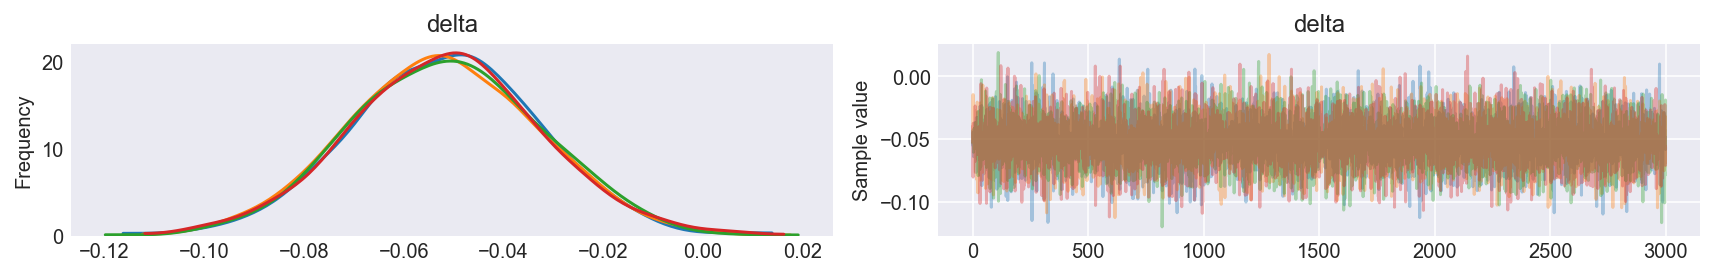

In [4]:
with pm.Model() as model1:
    theta1 = pm.Beta('theta1', alpha=1, beta=1)
    theta2 = pm.Beta('theta2', alpha=1, beta=1)
    delta = pm.Deterministic('delta', theta1-theta2)
    
    s1 = pm.Binomial('s1', p=theta1, n=n1, observed=s1)
    s2 = pm.Binomial('s2', p=theta2, n=n2, observed=s2)
    trace1=pm.sample(3000)

pm.traceplot(trace1, varnames=['delta']);

In [8]:
def display_BF(trace, x, varname, zoom=True):
    if zoom:
        _, ax = plt.subplots(1, 2, figsize=(12,5))
        ax1 = ax[0]
    else:
        _, ax1 = plt.subplots(1, 1, figsize=(6,5))
    # BFs based on density estimation (using kernel smoothing instead of spline)
    tmp = pm.summary(trace, varnames=[varname])
    # 95% confidence interval:
    x0 = tmp.values[0, 3]
    x1 = tmp.values[0, 4]

    t_delt = trace[varname]
    my_pdf = gaussian_kde(t_delt)
    ax1.plot(x, my_pdf(x), '--', lw=2.5, alpha=0.6, label='Posterior') # distribution function
    ax1.plot(x, cauchy.pdf(x), 'r-', lw=2.5, alpha=0.6, label='Prior')
    posterior = my_pdf(0)             # this gives the pdf at point delta = 0
    prior     = cauchy.pdf(0)         # height of order-restricted prior at delta = 0
    BF01      = posterior/prior
    print ('the Bayes Factor is %.5f' %(BF01))
    ax1.plot([0, 0], [posterior, prior], 'k-', 
            [0, 0], [posterior, prior], 'ko', lw=1.5, alpha=1)
    ax1.set_xlabel('Delta')
    ax1.set_ylabel('Density')
    ax1.legend(loc='upper left');
    
    if zoom:
        x = np.linspace(-.01, .01, 20)
        ax[1].plot(x, my_pdf(x), '--', lw=2.5, alpha=0.6, label='Posterior') # distribution function
        ax[1].plot(x, cauchy.pdf(x), 'r-', lw=2.5, alpha=0.6, label='Prior')
        ax[1].plot([0, 0], [posterior, prior], 'k-', 
                   [0, 0], [posterior, prior], 'ko', 
                   lw=1.5, alpha=1)
        ax[1].set_xlabel('Delta')
        ax[1].set_ylabel('Density')
        ax[1].legend(loc='upper left')
        plt.tight_layout();

the Bayes Factor is 1.54678


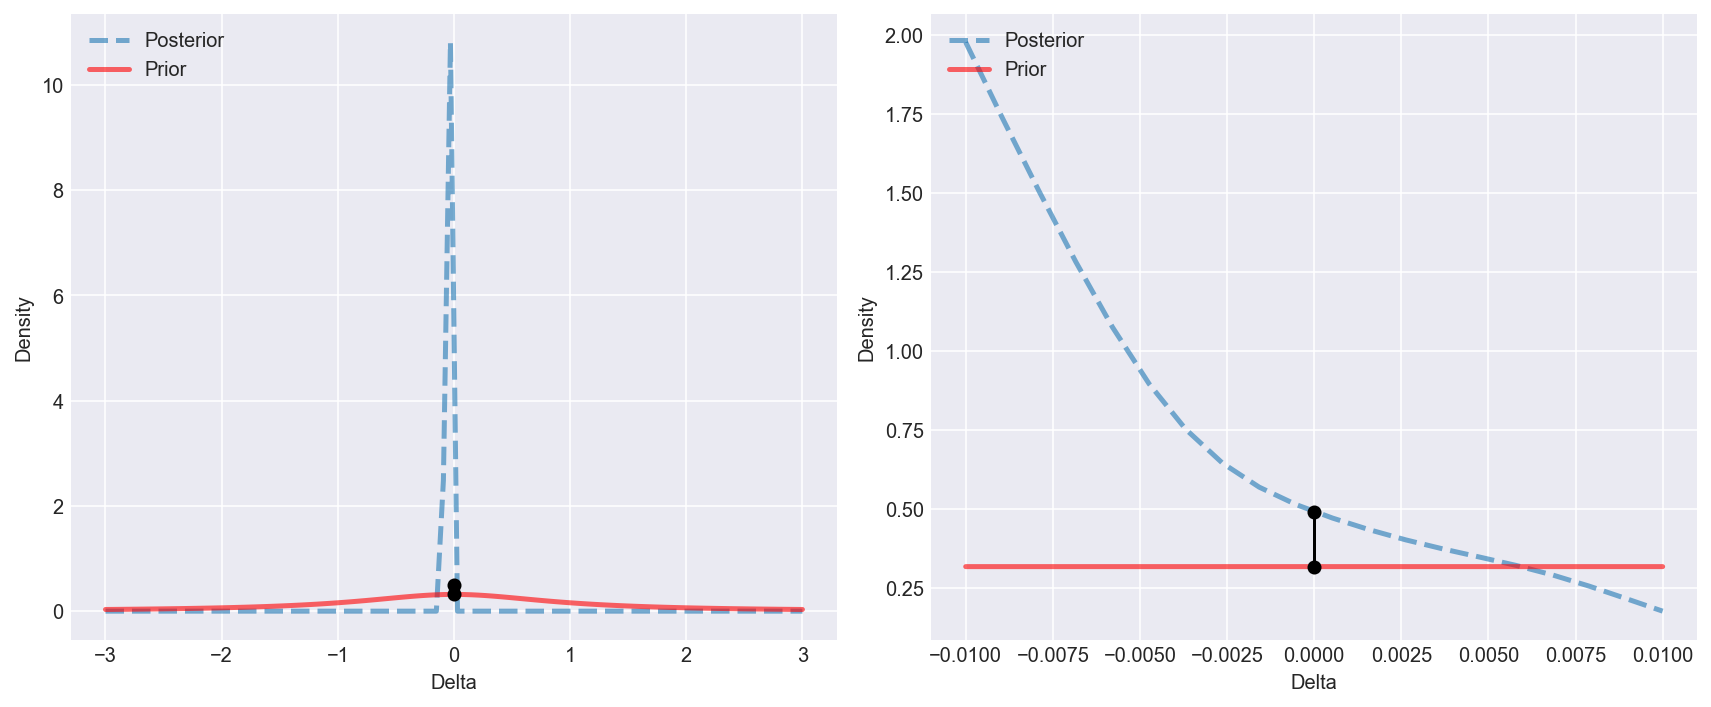

In [6]:
x = np.linspace(-3, 3, 100)
display_BF(trace1, x, 'delta')

## 9.2 Order-restricted equality of proportions


$$ s_{1} \sim \text{Binomial}(\theta_{1},n_{1})$$
$$ s_{2} \sim \text{Binomial}(\theta_{2},n_{2})$$
$$ (\theta_{1},\theta_{2}) \sim \text{Uniform}(0,1)^2, \theta_{2} \gt \theta_{1}$$
$$ \delta = \theta_{1} -\theta_{2}$$ 

In [4]:
def phi(x):
    #'Cumulative distribution function for the standard normal distribution'
    # pm.math.erf: error function Gauss error function https://en.wikipedia.org/wiki/Error_function
    return 0.5 + 0.5 * pm.math.erf(x/pm.math.sqrt(2))

def normcdf1(thetap1, thetap2):
    angle = 45*np.pi/180
    return phi((np.cos(angle) * thetap1) - (np.sin(angle) * tt.abs_(thetap2)))

def normcdf2(thetap1, thetap2):
    angle = 45*np.pi/180
    return phi((np.sin(angle) * thetap1) + (np.cos(angle) * tt.abs_(thetap2)))

with pm.Model() as modelAE:
    # the Approximate method
    theta2a = pm.Uniform('theta2a', lower=0, upper=1)
    theta1a = pm.Uniform('theta1a', lower=0, upper=theta2a)
    deltaa = pm.Deterministic('deltaa', theta1a-theta2a)
    
    ## the Exact method
    # Adaptation of the exact method as in the book using joint samples from a
    # bivariate standard Gaussian then rotating them by 45 degree. The rotated
    # sample is transform tinto rates that lie in the unit square
    thetap = pm.MvNormal('thetap', mu=[0, 0], tau=pm.math.constant(np.eye(2)), shape=2)
    
    theta1e = pm.Deterministic('theta1e', normcdf1(thetap[0], thetap[1]))
    theta2e = pm.Deterministic('theta2e', normcdf2(thetap[0], thetap[1]))
    
    deltae = pm.Deterministic('deltae', theta1e-theta2e)

    traceAE=pm.sample(3000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [thetap, theta1a_interval__, theta2a_interval__]
100%|██████████| 4000/4000 [00:04<00:00, 911.47it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '59064' (I am process '59065')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/smuch/.theano/compiledir_Darwin-17.5.0-x86_64-i386-64bit-i386-3.6.4-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '59064' (I am process '59067')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/smuch/.theano/compiledir_Darwin-17.5.0-x86_64-i386-64bit-i386-3.6.4-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '59065' (I am process '59067')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/smuch/.theano/compiledir_Darwin-17.5.0-x86_64-i386-64bit-i386-3.6.4-64/lock_dir


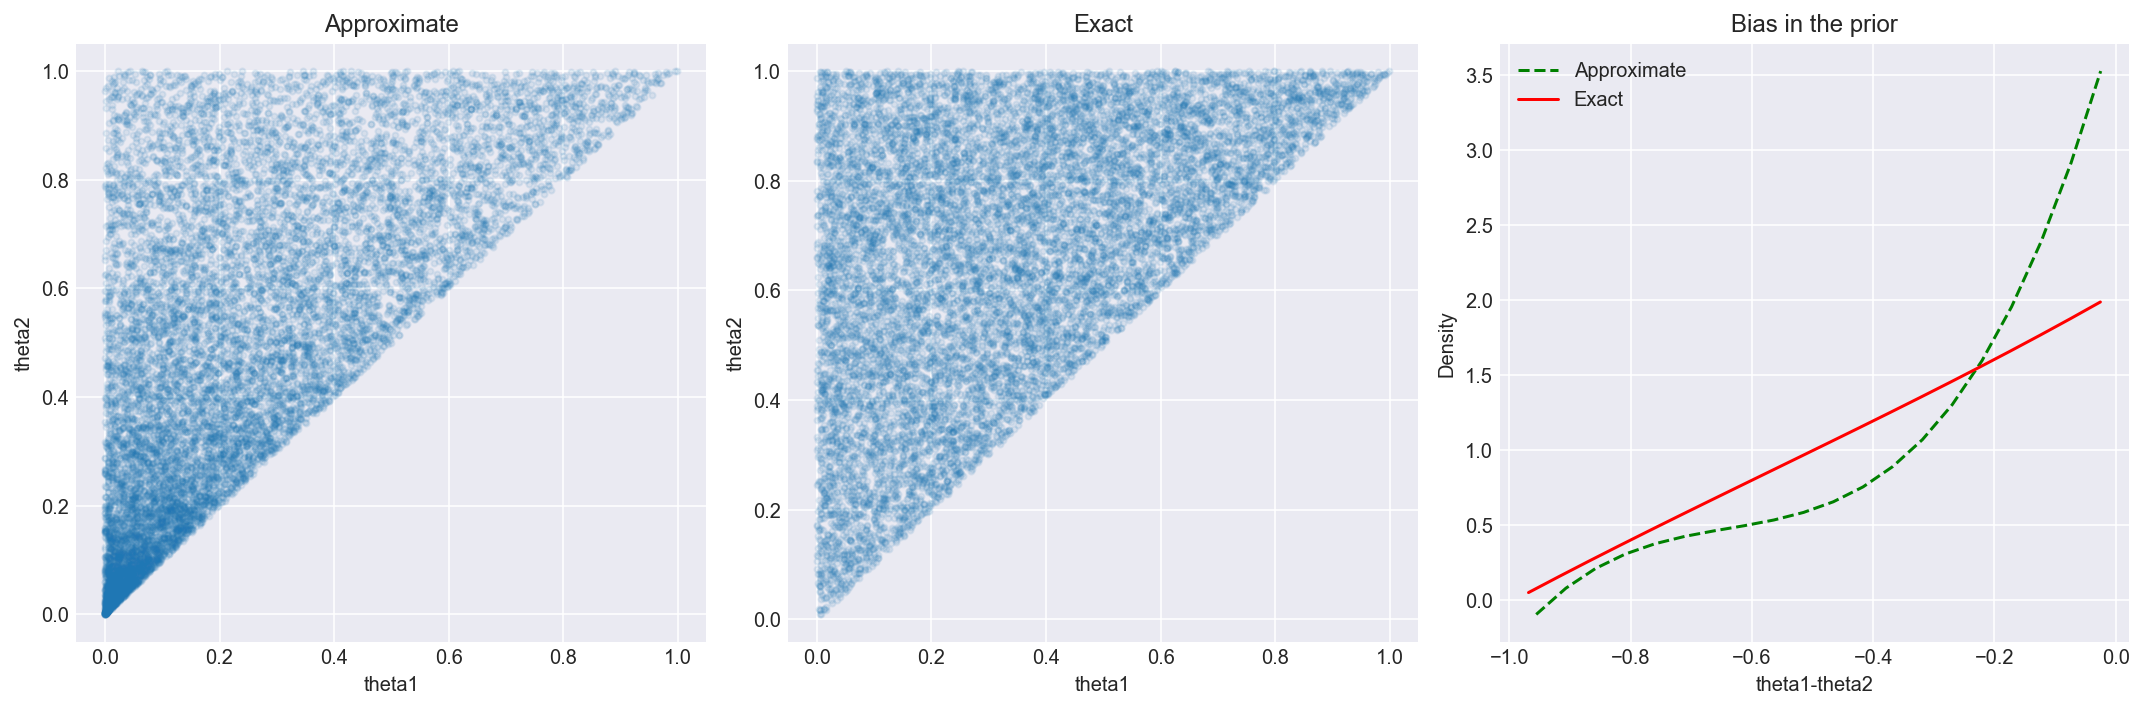

In [9]:
_, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(traceAE['theta1a'][:], traceAE['theta2a'][:], '.', alpha=.1)
ax[0].set_xlabel('theta1')
ax[0].set_ylabel('theta2')
ax[0].set_title('Approximate')

ax[1].plot(traceAE['theta1e'][:], traceAE['theta2e'][:], '.', alpha=.1)
ax[1].set_xlabel('theta1')
ax[1].set_ylabel('theta2')
ax[1].set_title('Exact')

from scipy.interpolate import UnivariateSpline
y, binEdges = np.histogram(traceAE['deltaa'][:], bins=20, normed=True)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
s = UnivariateSpline(bincenters, y, s=1)
ax[2].plot(bincenters,s(bincenters), 'g--', label='Approximate')

y2,binEdges2=np.histogram(traceAE['deltae'][:], bins=20, normed=True)
bincenters2 = 0.5*(binEdges2[1:]+binEdges2[:-1])
s2 = UnivariateSpline(bincenters2, y2, s=1)
ax[2].plot(bincenters2, s2(bincenters2), 'r-', label='Exact')

ax[2].set_xlabel('theta1-theta2')
ax[2].set_ylabel('Density')
ax[2].set_title('Bias in the prior')
ax[2].legend(loc='upper left')
plt.tight_layout()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [thetap]
100%|██████████| 2000/2000 [00:03<00:00, 631.42it/s]
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6088557152038994, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8835053685146136, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9454010633354143, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


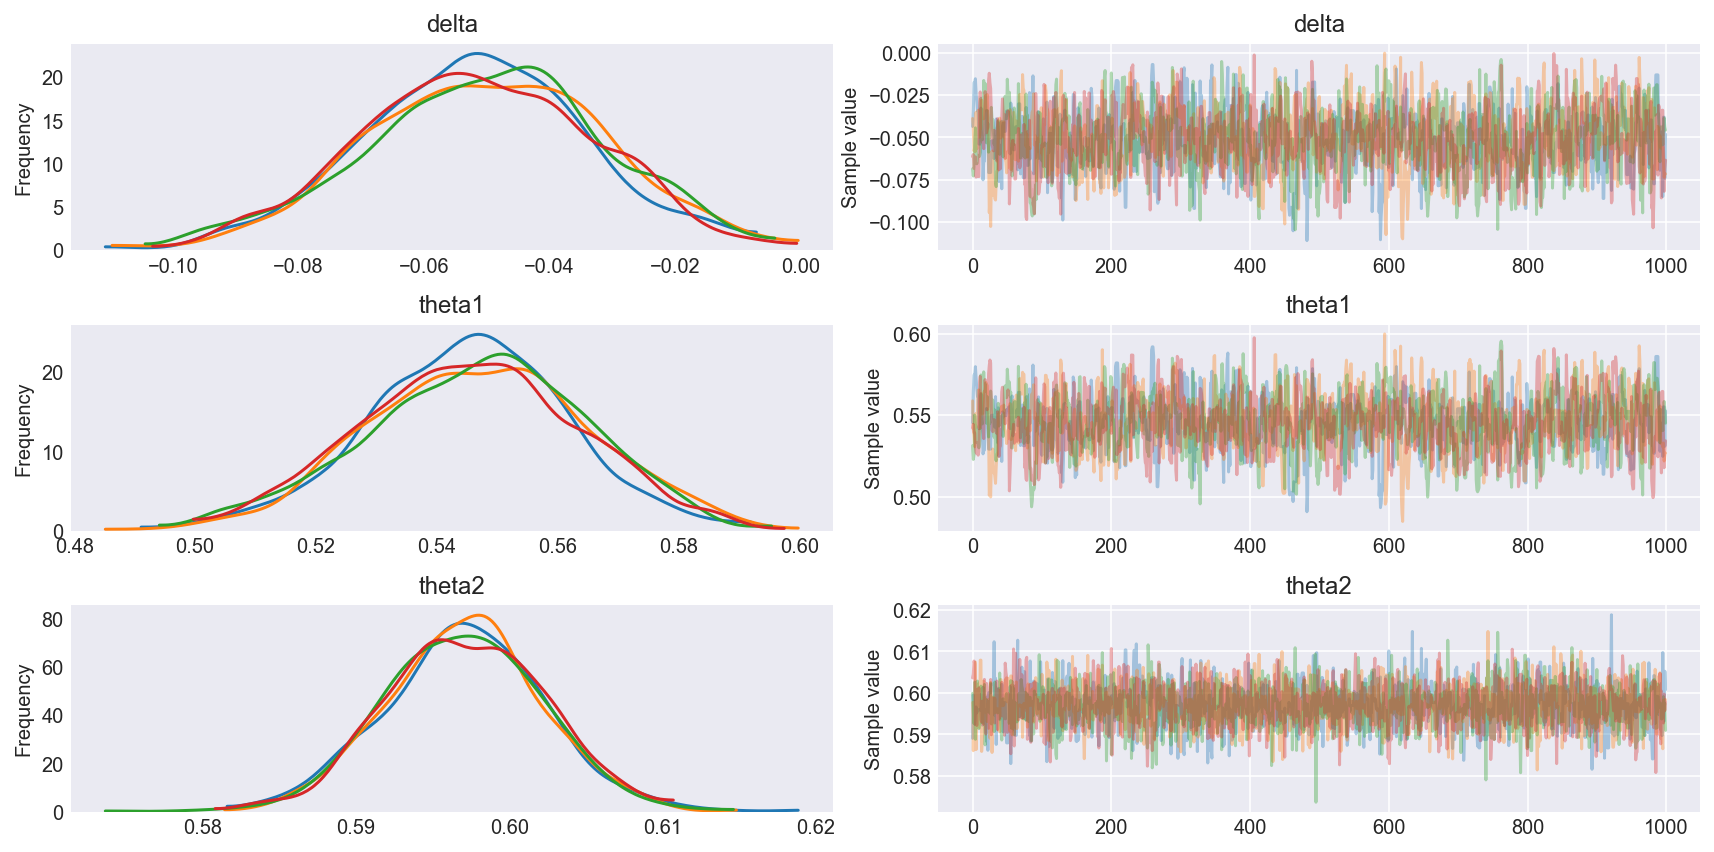

In [10]:
# pledger data:
s1 = 424
s2 = 5416
n1 = 777
n2 = 9072

with pm.Model() as model2:
    ## the Exact method
    # Adaptation of the exact method as in the book using joint samples from a
    # bivariate standard Gaussian then rotating them by 45 degree. The rotated
    # sample is transform tinto rates that lie in the unit square
    thetap = pm.MvNormal('thetap', mu=[0, 0], tau= pm.math.constant(np.eye(2)), shape=2)

    theta1 = pm.Deterministic('theta1', normcdf1(thetap[0], thetap[1]))
    theta2 = pm.Deterministic('theta2', normcdf2(thetap[0], thetap[1]))

    ## the Approximate method
    # theta2 = pm.Uniform("theta2",lower=0,upper=1)
    # theta1 = pm.Uniform("theta1",lower=0,upper=theta2)
    
    delta = pm.Deterministic('delta', theta1-theta2)
    
    so1 = pm.Binomial('so1', p=theta1, n=n1, observed=s1)
    so2 = pm.Binomial('so2', p=theta2, n=n2, observed=s2)
    
    trace2 = pm.sample(1000, tune=1000)

pm.traceplot(trace2, varnames=['delta', 'theta1', 'theta2']);

the Bayes Factor is 0.80563


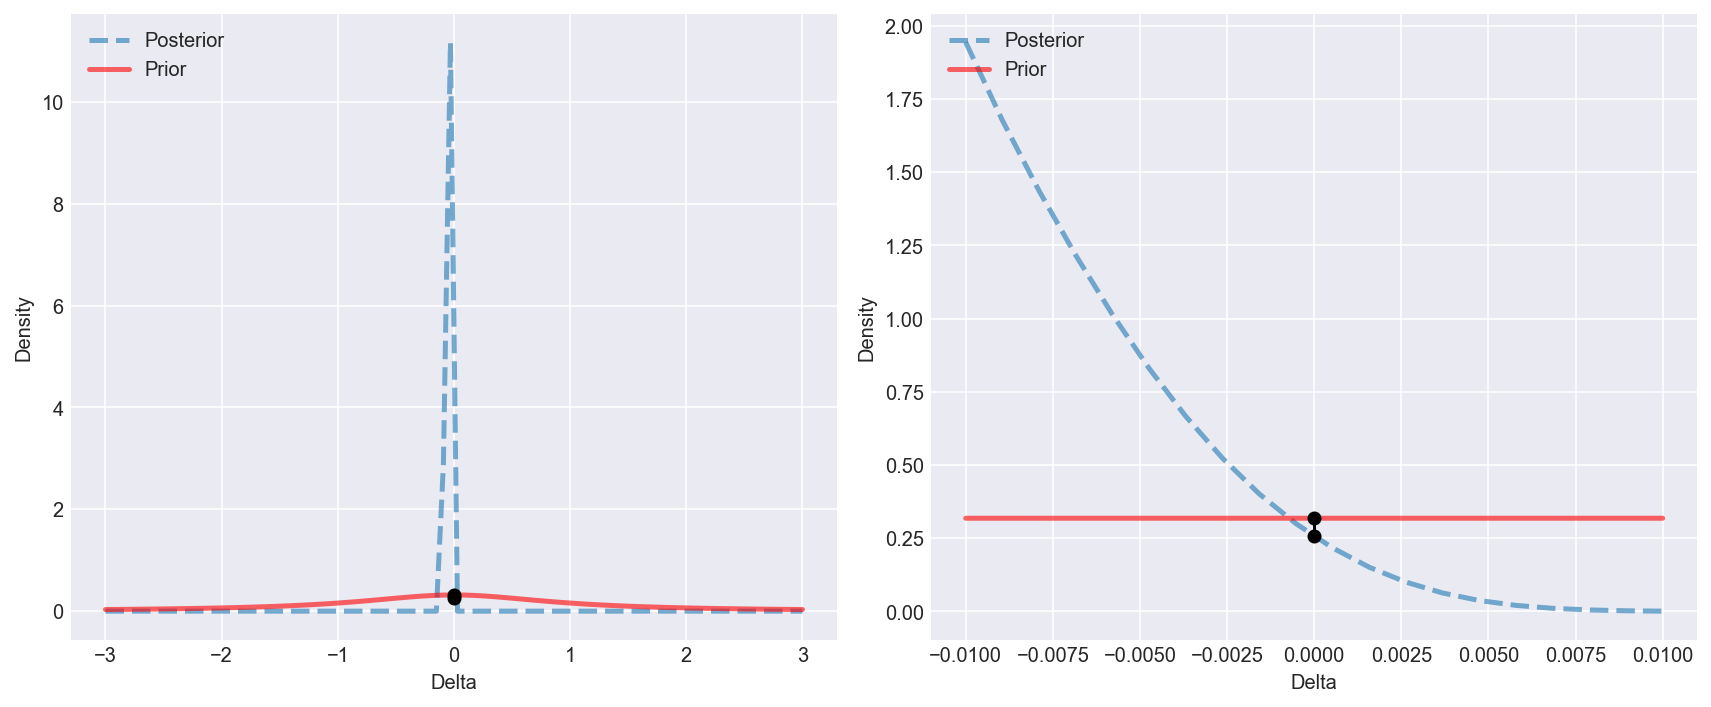

In [11]:
pm.summary(trace2, varnames=['delta'])
x = np.linspace(-3, 3, 100)
display_BF(trace2, x, 'delta')

## 9.3 Comparing within-subject proportions

$$ \mu \sim \text{Gaussian}(0,1)_{\mathcal I(0,∞)}$$
$$ \sigma \sim \text{Uniform}(0,10)$$
$$ \delta \sim \text{Gaussian}(0,1)_{\mathcal I(0,∞)}$$
$$ \sigma_{\alpha} \sim \text{Uniform}(0,10)$$
$$ \mu_{\alpha} = \delta\sigma_{\alpha}$$
$$ \alpha_{i} \sim \text{Gaussian}(\mu_{\alpha},1/\sigma^2_{\alpha})$$
$$ \phi^n_{i} \sim \text{Gaussian}(\mu,1/\sigma^2)$$
  
$$ \phi^b_{i} = \phi^n_{i}+\alpha_{i}$$
$$ \theta^n_{i} = \Phi(\phi^n_{i})$$
$$ \theta^b_{i} = \Phi(\phi^b_{i})$$
  
$$ s^n_{i} \sim \text{Binomial}(\theta^n_{i},n^n)$$
$$ s^b_{i} \sim \text{Binomial}(\theta^b_{i},n^b)$$

In [12]:
### Zeelenberg data:
# Study Both:         
sb = np.array([15,11,15,14,15,18,16,16,18,16,15,13,18,12,11,13,17,18,16,11,17,18,
        12,18,18,14,21,18,17,10,11,12,16,18,17,15,19,12,21,15,16,20,15,19,
        16,16,14,18,16,19,17,11,19,18,16,16,11,19,18,12,15,18,20, 8,12,19,
        16,16,16,12,18,17,11,20])
nb = 21

# Study Neither: 
sn = np.array([15,12,14,15,13,14,10,17,13,16,16,10,15,15,10,14,17,18,19,12,19,18,
        10,18,16,13,15,20,13,15,13,14,19,19,19,18,13,12,19,16,14,17,15,16,
        15,16,13,15,14,19,12,11,17,13,18,13,13,19,18,13,13,16,18,14,14,17,
        12,12,16,14,16,18,13,13])
nn = 21
ns = len(sb)

# two-sided p-value = .03
stats.ttest_rel(sb,sn)

Ttest_relResult(statistic=2.1857463052684696, pvalue=0.0320421840966393)

In [13]:
with pm.Model() as model3:
    mu = pm.HalfNormal('mu',sd=1)# standard Gaussian distribution prior. It is known as
                                 # the "unit information prior", as it carries as much 
                                 # information as a single observation (Kass & Wasserman, 1995)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    delta = pm.HalfNormal('delta', sd=1)
    sigma_alpha = pm.Uniform('sigma_alpha', lower=0, upper=10)
    
    mu_alpha = delta*sigma_alpha
    
    alpha_i = pm.Normal('alpha_i', mu=mu_alpha, sd=sigma_alpha, shape=ns)
    phin = pm.Normal('phin', mu=mu, sd=sigma, shape=ns)
    
    phib = phin + alpha_i
    # 欧拉函数
    thetan = pm.Deterministic('thetan', phi(phin))
    thetab = pm.Deterministic('thetab', phi(phib))
    
    sno = pm.Binomial('sno', p=thetan, n=nn, observed=sn)
    sbo = pm.Binomial('sbo', p=thetab, n=nb, observed=sb)
    
    trace3 = pm.sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phin, alpha_i, sigma_alpha_interval__, delta_log__, sigma_interval__, mu_log__]
100%|██████████| 3500/3500 [00:23<00:00, 152.12it/s]
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
There were 225 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6984214094405615, but should be close to 0.8. Try to increase the number of tuning steps.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6805284419989874, but should be close to 0.8. Try to increase the number of tuning steps.
There were 194 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6666590609060425, but should be close

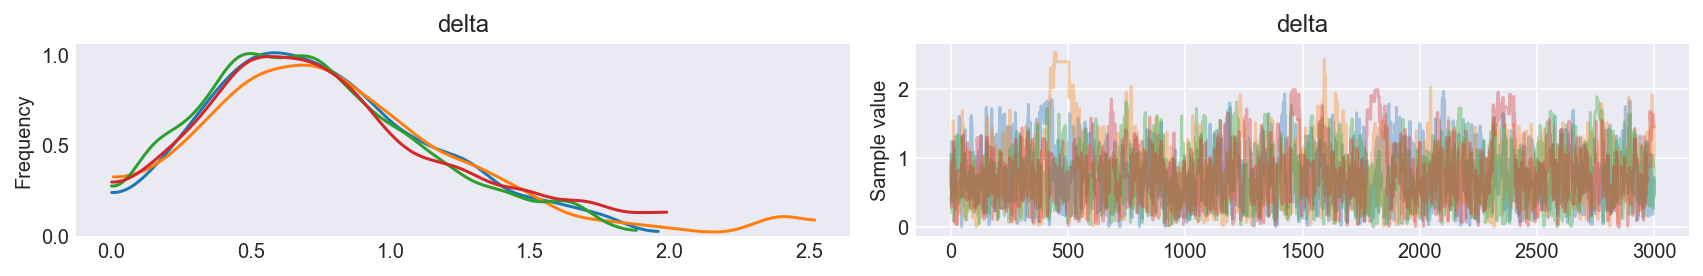

In [14]:
pm.traceplot(trace3, varnames=['delta']);

the Bayes Factor is 0.42274


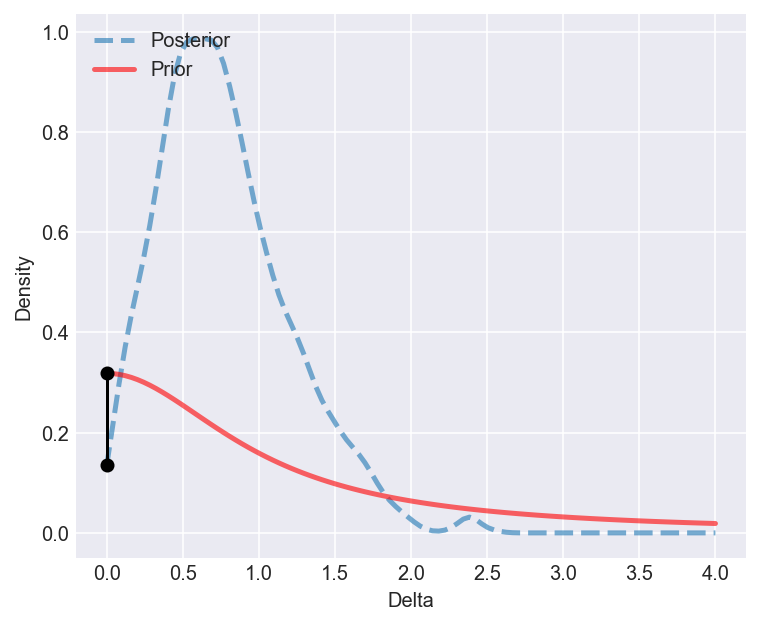

In [15]:
x = np.linspace(0, 4, 100)
display_BF(trace3, x, 'delta', zoom=False)

## 9.4 Comparing between-subject proportions

$$ \delta \sim \text{Gaussian}(0,1)_{\mathcal I(0,∞)}$$
$$ \mu \sim \text{Gaussian}(0,1)$$
$$ \sigma \sim \text{Uniform}(0,10)$$
$$ \alpha = \delta\sigma$$
  
$$ \phi^c_{i} \sim \text{Gaussian}(\mu\,+\alpha/2,1/\sigma^2)$$
$$ \phi^a_{j} \sim \text{Gaussian}(\mu\,-\alpha/2,1/\sigma^2)$$
  
$$ \theta^c_{i} = \Phi(\phi^c_{i})$$
$$ \theta^a_{j} = \Phi(\phi^a_{j})$$
  
$$ s^c_{i} \sim \text{Binomial}(\theta^c_{i},n^c_{i})$$
$$ s^a_{j} \sim \text{Binomial}(\theta^a_{j},n^a_{j})$$

In [2]:
### Geurts data:
# Normal Controls:         
numerrors1 = np.array([15,10,61,11,60,44,63,70,57,11,67,21,89,12,63,11,96,10,37,19,44,
                18,78,27,60,14])
nc         = np.array([89,74,128,87,128,121,128,128,128,78,128,106,128,83,128,100,128,
                73,128,86,128,86,128,100,128,79])
kc         = nc - numerrors1
nsc        = len(kc)
# ADHD:
numerrors2 = np.array([88,50,58,17,40,18,21,50,21,69,19,29,11,76,46,36,37,72,27,92,13,
                39,53,31,49,57,17,10,12,21,39,43,49,17,39,13,68,24,21,27,48,54,
                41,75,38,76,21,41,61,24,28,21])
na         = np.array([128,128,128,86,128,117,89,128,110,128,93,107,87,128,128,113,128,
                128,98,128,93,116,128,116,128,128,93,86,86,96,128,128,128,86,128,
                78,128,111,100,95,128,128,128,128,128,128,98,127,128,93,110,96])
ka         = na - numerrors2
nsa        = len(ka)

# two-sided p-value = .72
stats.ttest_ind(kc/nc,ka/na,equal_var=False)

Ttest_indResult(statistic=-0.3671153138223306, pvalue=0.7154583192501404)

In [5]:
with pm.Model() as model4:
    delta = pm.Normal('delta', mu=0, sd=1)
    mu_   = pm.Normal('mu', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    alpha = delta*sigma
    
    phic  = pm.Normal('phic', mu=mu_+alpha/2, tau=1/sigma**2, shape=nsc)
    phia  = pm.Normal('phia', mu=mu_-alpha/2, tau=1/sigma**2, shape=nsa)
    #phi() 'Cumulative distribution function for the standard normal distribution'
    thetac = pm.Deterministic('thetac', phi(phic))
    thetaa = pm.Deterministic('thetaa', phi(phia))
    
    kco = pm.Binomial('kco', p=thetac, n=nc, observed=kc)
    kao = pm.Binomial('kao', p=thetaa, n=na, observed=ka)
    
    trace4 = pm.sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phia, phic, sigma_interval__, mu, delta]
100%|██████████| 3500/3500 [00:07<00:00, 481.51it/s]


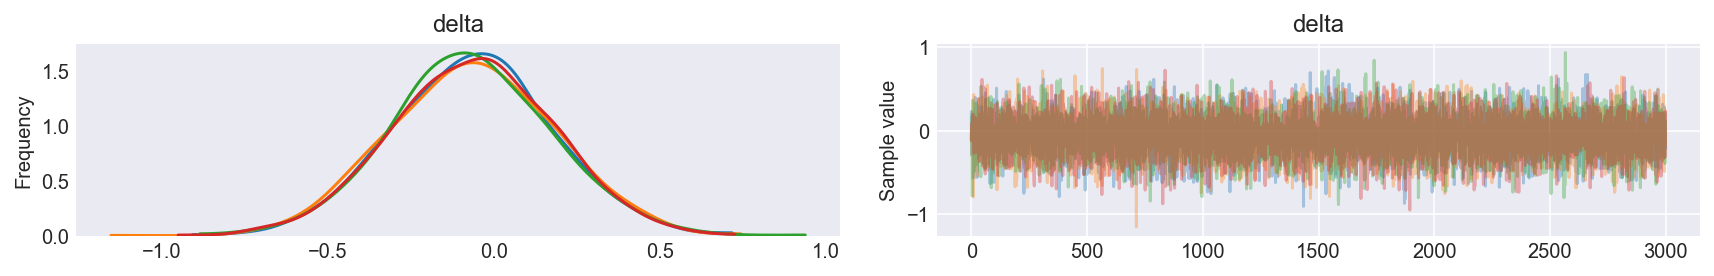

In [6]:
pm.traceplot(trace4, varnames=['delta']);

the Bayes Factor is 5.09322


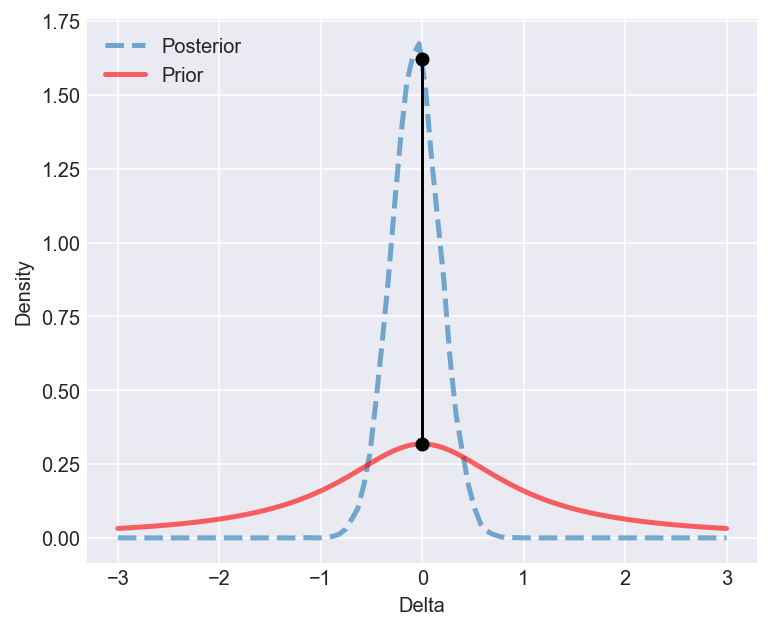

In [10]:
x = np.linspace(-3, 3, 100)
display_BF(trace4, x, 'delta', zoom=False)

## 9.5 Order-restricted between-subjects comparison

$$ \delta \sim \text{Gaussian}(0,1)_{\mathcal I(0,∞)}$$
$$ \mu \sim \text{Gaussian}(0,1)$$
$$ \sigma \sim \text{Uniform}(0,10)$$
$$ \alpha = \delta\sigma$$
  
$$ \phi^c_{i} \sim \text{Gaussian}(\mu\,+\alpha/2,1/\sigma^2)$$
$$ \phi^a_{j} \sim \text{Gaussian}(\mu\,-\alpha/2,1/\sigma^2)$$
  
$$ \theta^c_{i} = \Phi(\phi^c_{i})$$
$$ \theta^a_{j} = \Phi(\phi^a_{j})$$
  
$$ s^c_{i} \sim \text{Binomial}(\theta^c_{i},n^c_{i})$$
$$ s^a_{j} \sim \text{Binomial}(\theta^a_{j},n^a_{j})$$

In [11]:
with pm.Model() as model5:
    delta = pm.HalfNormal('delta', sd=1)
    mu_   = pm.Normal('mu', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    alpha = delta*sigma
    
    phic  = pm.Normal('phic', mu=mu_+alpha/2, sd=sigma, shape=nsc)
    phia  = pm.Normal('phia', mu=mu_-alpha/2, sd=sigma, shape=nsa)
    
    thetac = pm.Deterministic('thetac', phi(phic))
    thetaa = pm.Deterministic('thetaa', phi(phia))
    
    kco = pm.Binomial('kco', p=thetac, n=nc, observed=kc)
    kao = pm.Binomial('kao', p=thetaa, n=na, observed=ka)
    
    trace5 = pm.sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phia, phic, sigma_interval__, mu, delta_log__]
100%|██████████| 3500/3500 [00:13<00:00, 266.17it/s]
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


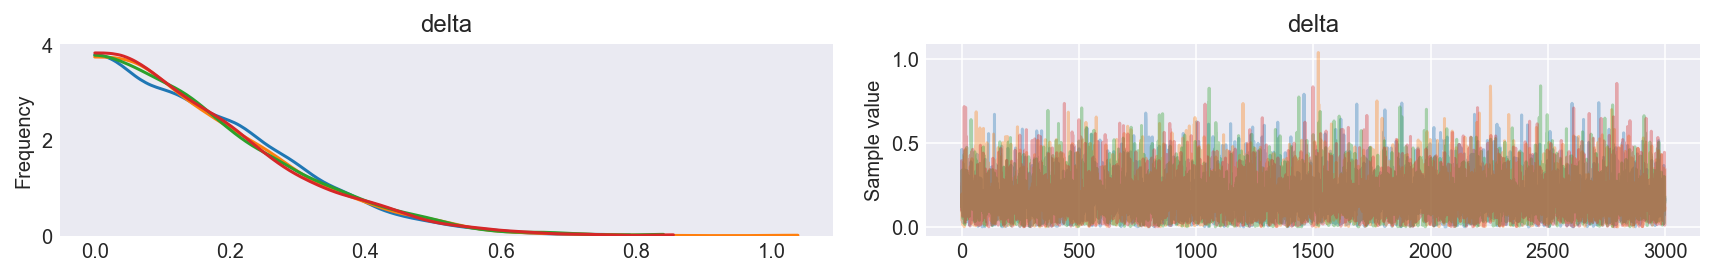

In [12]:
pm.traceplot(trace5, varnames=['delta']);

the Bayes Factor is 5.94759


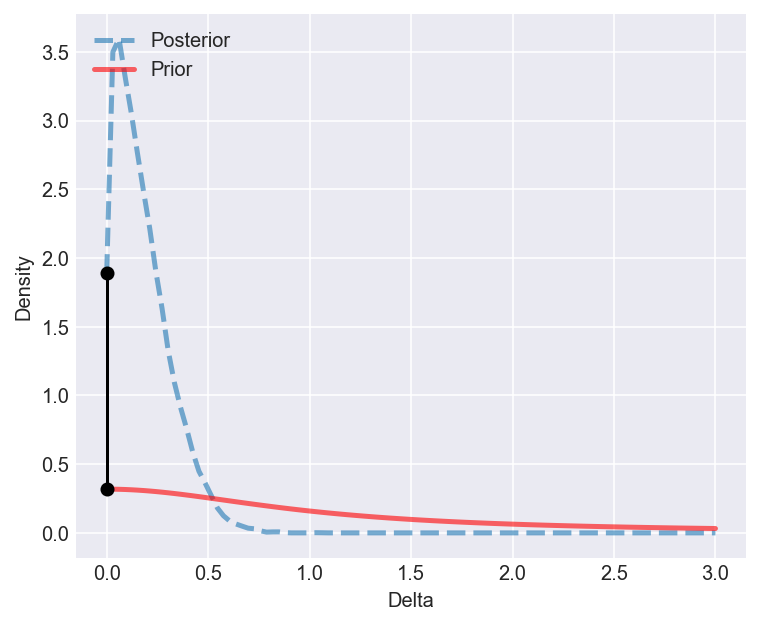

In [13]:
x = np.linspace(0, 3, 100)
display_BF(trace5, x, 'delta', zoom=False)